In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
# lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
# lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

# Lagrangian Methods

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    I, J = np.meshgrid(np.arange(i_left, i_right), np.arange(j_down, j_up))
    return I, J

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None



### Load Eddy Data

In [4]:
edata = eddies['Eddy19'].iloc[-1] #E22T5
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    U = np.transpose(U,axes=(3,2,1,0))
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    V = np.transpose(V,axes=(3,2,1,0))
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    Vorticity = np.transpose(Vorticity,axes=(3,2,1,0))
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    TemperatureAnomaly = np.transpose(TemperatureAnomaly,axes=(3,2,1,0))
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.transpose(CurSpeed,axes=(3,2,1,0))
    CurSpeedAnomaly = np.transpose(CurSpeedAnomaly,axes=(3,2,1,0))
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

### Choose DataField

In [5]:
import parcels
from datetime import timedelta
import xarray as xr

DataField = TemperatureAnomaly

DataField_name = get_variable_name(DataField)

DEPTH_LVL = 20
u_lvl = U[:,DEPTH_LVL,:,:]
v_lvl = V[:,DEPTH_LVL,:,:]
DataField = DataField[:,DEPTH_LVL,:,:]
data = {
    "U": u_lvl, "V": v_lvl, "temp": DataField
}
dims = {
    "lon": lon_rho, "lat": lat_rho, 'time': ocean_time
}
fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical", allow_time_extrapolation=True,)

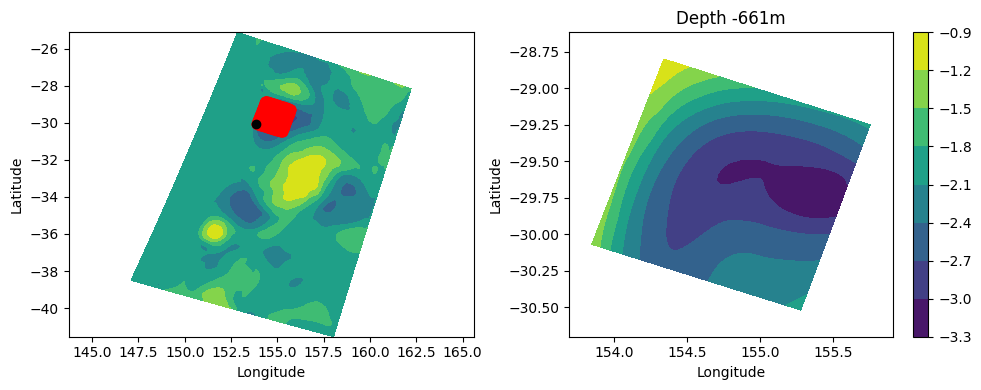

In [6]:
SEARCH_WIDTH = 150000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
I, J = grid_finder(i_search, j_search, SEARCH_WIDTH)

lon = lon_rho[J, I]
lat = lat_rho[J, I]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Plot 1: Contourf and Scatter
axs[0].contourf(fieldset.U.lon, fieldset.U.lat, fieldset.temp.data[t_mod, :, :])
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].axis('equal')
axs[0].scatter(lon, lat, color='r')
axs[0].scatter(lon.flatten()[0], lat.flatten()[0], color='k')

# for i, txt in enumerate(daydic['Day6'].index):
#     axs[0].text(daydic['Day6'].Lon[i], daydic['Day6'].Lat[i], txt)

# Plot 2: Contourf of vorticity level
contour_plot = axs[1].contourf(lon, lat, DataField[t_mod, J, I])
axs[1].set_title('Depth '+str(round(z_r[150,150,DEPTH_LVL]))+'m')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].axis('equal')
fig.colorbar(contour_plot, ax=axs[1])

plt.tight_layout()
plt.show()

### Compute Lagrangian Components

In [7]:
DAYS = 4 # Runtime length

SampleParticle = parcels.JITParticle.add_variable("temperature")
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.temp[time, particle.depth, particle.lat, particle.lon]
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon.flatten(), lat=lat.flatten(), time=ocean_time[0]
)
output_file = pset.ParticleFile(name="/srv/scratch/z5297792/zarr_files/SampleDataField.zarr", outputdt=timedelta(hours=1))
pset.execute(
    [parcels.AdvectionRK4, SampleT], runtime=timedelta(days=DAYS), dt=timedelta(minutes=5), output_file=output_file,
)

INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataField.zarr.
100%|██████████| 345600.0/345600.0 [01:09<00:00, 4972.15it/s]


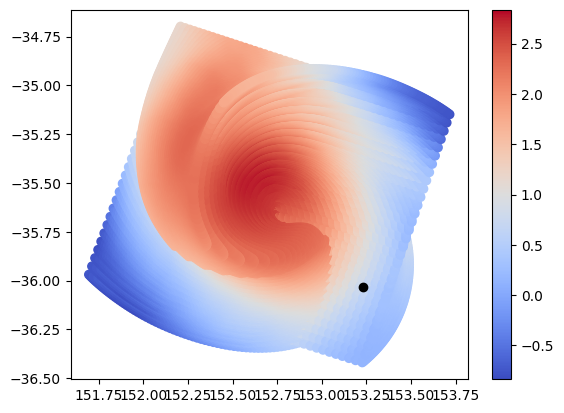

In [8]:
# Optional Plot
Particle_data = xr.open_zarr("/srv/scratch/z5297792/zarr_files/SampleDataField.zarr")
plt.figure()
ax = plt.axes()
# ax.plot(Particle_data.lon[0:6161:200,:].T, Particle_data.lat[0:6161:200,:].T, c="k", zorder=1)
DataField_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, c=Particle_data.temperature, cmap=plt.cm.coolwarm, zorder=2)
plt.plot(pset.lon[0], pset.lat[0], "ko")
plt.colorbar(DataField_scatter)
plt.show()


### LAVD Calculation

In [18]:
from scipy.interpolate import interp1d
import zarr
Particle_DataField = zarr.open("/srv/scratch/z5297792/zarr_files/SampleDataField.zarr", mode='r')
Curlz_t = Particle_DataField['temperature'][:].T
tspan = np.linspace(ocean_time[0],ocean_time[DAYS-1],DAYS*24)

Curlz_avg_t = np.mean(Curlz_t, axis=1)

# # Using Grid Average
# Curlz_avg_t = []
# for t in range(DAYS):
#     Curlz_avg_t.append(np.mean(DataField[t, J, I]))
# minutes_per_day = 24 * 60
# total_minutes = DAYS * minutes_per_day
# avg_per_day = Curlz_avg_t
# daily_times = np.linspace(0, DAYS, len(avg_per_day))
# new_times = np.arange(0, DAYS, 1/24)
# interpolator = interp1d(daily_times, avg_per_day, kind='linear', fill_value='extrapolate')
# Curlz_avg_t = interpolator(new_times)

# IVD = Curlz_t - Curlz_avg_t[:, np.newaxis]

# LAVD = abs(np.mean(IVD, axis=0))

fill = np.abs(Curlz_t - Curlz_avg_t[:, np.newaxis])
LAVD = np.trapezoid(fill, x=tspan, axis=0)

a, b = I.shape
LAVD = np.reshape(LAVD, (a, b))

### Plot

In [19]:
def find_extrema_2d(matrix):
    rows, cols = matrix.shape
    maxima = []
    minima = []

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # Extract the 3x3 neighborhood
            neighborhood = matrix[i-1:i+2, j-1:j+2].flatten()
            center = matrix[i, j]
            
            if center > np.max(np.delete(neighborhood, 4)):
                maxima.append((i, j))
            elif center < np.min(np.delete(neighborhood, 4)):
                minima.append((i, j))
    
    return maxima, minima

def matrix_range(matrix):
    return np.nanmax(matrix) - np.nanmin(matrix)

from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon
def IsContourConvex(xt, yt, DeficiencyThresh):
    points = list(zip(xt, yt))
    hull = ConvexHull(points, qhull_options='QJ')
    HullArea = hull.volume  # In 2D, volume is the area
    polygon = Polygon(points)
    Area = polygon.area
    if Area == 0:
        return False
    AreaDeficiency = abs(HullArea - Area) / Area * 100
    return AreaDeficiency <= DeficiencyThresh

def IsContourClosed(xt, yt, tolerance=1e-6):
    return len(xt) > 0 and len(yt) > 0 and (abs(xt[0] - xt[-1]) < tolerance) and (abs(yt[0] - yt[-1]) < tolerance)

def is_point_inside_contour(x_coords, y_coords, px, py):
    contour = Polygon(zip(x_coords, y_coords))
    point = Point(px, py)
    return contour.contains(point)

from scipy.interpolate import griddata
def max_closed_convex_contour_finder(xc_max, yc_max, x, y, DF, num_contours):

    X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    Z = griddata((x, y), DF, (X, Y), method='linear')
    
    data_range = matrix_range(Z)
    largest_contour_xt, largest_contour_yt = [], []
    for k in range(1, num_contours + 1):

        level_to_extract = np.nanmax(Z) - k * data_range / num_contours
        fig, ax = plt.subplots()
        c = ax.contour(X, Y, Z, levels=[level_to_extract], linewidths=1, colors='k')
        for level_paths in c.allsegs:
            for path in level_paths:
                xt = path[:, 0]
                yt = path[:, 1]
        plt.close(fig)
        if IsContourClosed(xt, yt):
            if IsContourConvex(xt, yt, DeficiencyThresh=2):
                if is_point_inside_contour(xt, yt, xc_max, yc_max):
                    if len(xt) > len(largest_contour_xt):
                        largest_contour_xt, largest_contour_yt = xt, yt
    df = pd.DataFrame({'xt': largest_contour_xt, 'yt': largest_contour_yt})
    return df

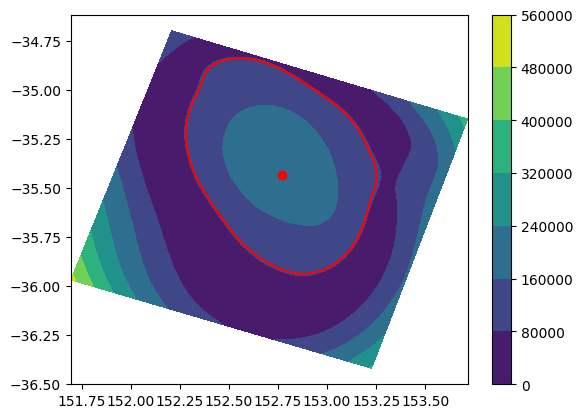

In [20]:
plt.contourf(lon, lat, LAVD)
plt.colorbar()
# plt.scatter(edata.Lon, edata.Lat, color='k', marker='x')

maxima, minima = find_extrema_2d(LAVD)
if maxima:
    a, b = zip(*maxima)
    plt.scatter(lon[a,b], lat[a,b], color='red', label='Maxima', marker='o')
# if minima:
#     a, b = zip(*minima)
#     plt.scatter(lon[a,b], lat[a,b], color='blue', label='Minima', marker='x')
plt.axis('equal')

for a, b in maxima:
    df =  max_closed_convex_contour_finder(lon[a,b], lat[a, b], lon.flatten(), lat.flatten(), LAVD.flatten(), num_contours=100)
    plt.plot(df.xt, df.yt, color='r')
    # df.plot(x='xt', y='yt', ax=plt.gca(), kind='line', color='red', label=None)


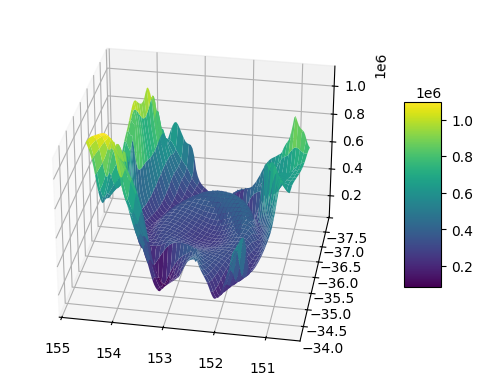

In [80]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D surface
surf = ax.plot_surface(lon, lat, LAVD, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=100)

## For Full Depth Application

In [48]:
import parcels
from datetime import timedelta
import xarray as xr
from scipy.interpolate import interp1d
import zarr

DataField = TemperatureAnomaly

DataField_name = get_variable_name(DataField)

DEPTH_LVL_LIMIT = 15
SEARCH_WIDTH = 300000
DAYS = 4 # Runtime length

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
I, J = grid_finder(i_search, j_search, SEARCH_WIDTH)
lon, lat = lon_rho[J, I], lat_rho[J, I]

VMatrix = np.full((I.shape[0], I.shape[1], DEPTH_LVL_LIMIT), np.nan)

for depth in range(DEPTH_LVL_LIMIT):

    u_lvl = U[:,depth,:,:]
    v_lvl = V[:,depth,:,:]
    DataField_lvl = DataField[:,depth,:,:]
    data = {
        "U": u_lvl, "V": v_lvl, "temp": DataField_lvl
    }
    dims = {
        "lon": lon_rho, "lat": lat_rho, 'time': ocean_time
    }
    fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical", allow_time_extrapolation=True)

    SampleParticle = parcels.JITParticle.add_variable("temperature")
    def SampleT(particle, fieldset, time):
        particle.temperature = fieldset.temp[time, particle.depth, particle.lat, particle.lon]
    pset = parcels.ParticleSet(
        fieldset=fieldset, pclass=SampleParticle, lon=lon.flatten(), lat=lat.flatten(), time=ocean_time[0]
    )
    output_file = pset.ParticleFile(name="/srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr", outputdt=timedelta(hours=1))
    pset.execute(
        [parcels.AdvectionRK4, SampleT], runtime=timedelta(days=DAYS), dt=timedelta(minutes=5), output_file=output_file,
    )

    Particle_DataField = zarr.open("/srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr", mode='r')
    Curlz_t = Particle_DataField['temperature'][:].T
    tspan = np.linspace(ocean_time[0],ocean_time[DAYS-1],DAYS*24)
    
    Curlz_avg_t = np.mean(Curlz_t, axis=1)

    LAVD = np.reshape(np.trapezoid(np.abs(Curlz_t - Curlz_avg_t[:, np.newaxis]), x=tspan, axis=0), I.shape)

    VMatrix[:, :, depth] = LAVD


INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr.
100%|██████████| 345600.0/345600.0 [01:12<00:00, 4756.86it/s]
INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr.
100%|██████████| 345600.0/345600.0 [01:09<00:00, 4944.46it/s]
INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr.
100%|██████████| 345600.0/345600.0 [01:10<00:00, 4880.63it/s]
INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr.
100%|██████████| 345600.0/345600.0 [01:10<00:00, 4936.29it/s]
INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr.
100%|██████████| 345600.0/345600.0 [01:09<00:00, 4946.94it/s]
INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/SampleDataFieldDepth.zarr.
100%|██████████| 345600.0/345600.0 [01:10<00:00, 4902.30it/s]
INFO: Output files are stored in /srv/scratch/z5297792/zarr_files/Samp

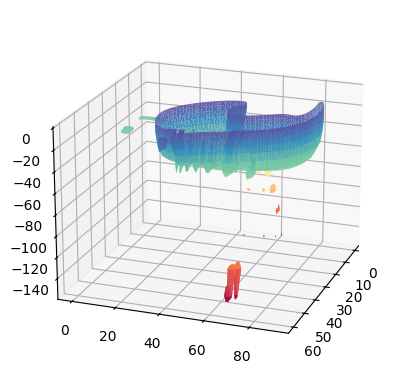

In [68]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

# bnd.cval is the isosurface value
cval = 50000

# Compute the isosurface
verts, faces, normals, values = measure.marching_cubes(VMatrix, level=cval)

# Map each z-coordinate (slice index) to the actual depth
z_coords = np.interp(verts[:, 2], np.arange(DEPTH_LVL_LIMIT), z_r[150, 150, :DEPTH_LVL_LIMIT])
verts[:, 2] = z_coords

# Plotting the isosurface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], cmap='Spectral', lw=1)

ax.view_init(elev=20, azim=20)

plt.show()
